**Data Preparation**

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
dataset = pd.read_csv('/content/energydata_complete.csv')
dataset.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [4]:
dataset.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [5]:
nRow, nCol = dataset.shape
print(f'Sampel ada {nRow} baris dan {nCol} kolom, Lebih dari 10000 sampel.')

Sampel ada 19735 baris dan 29 kolom, Lebih dari 10000 sampel.


In [6]:
dataset.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

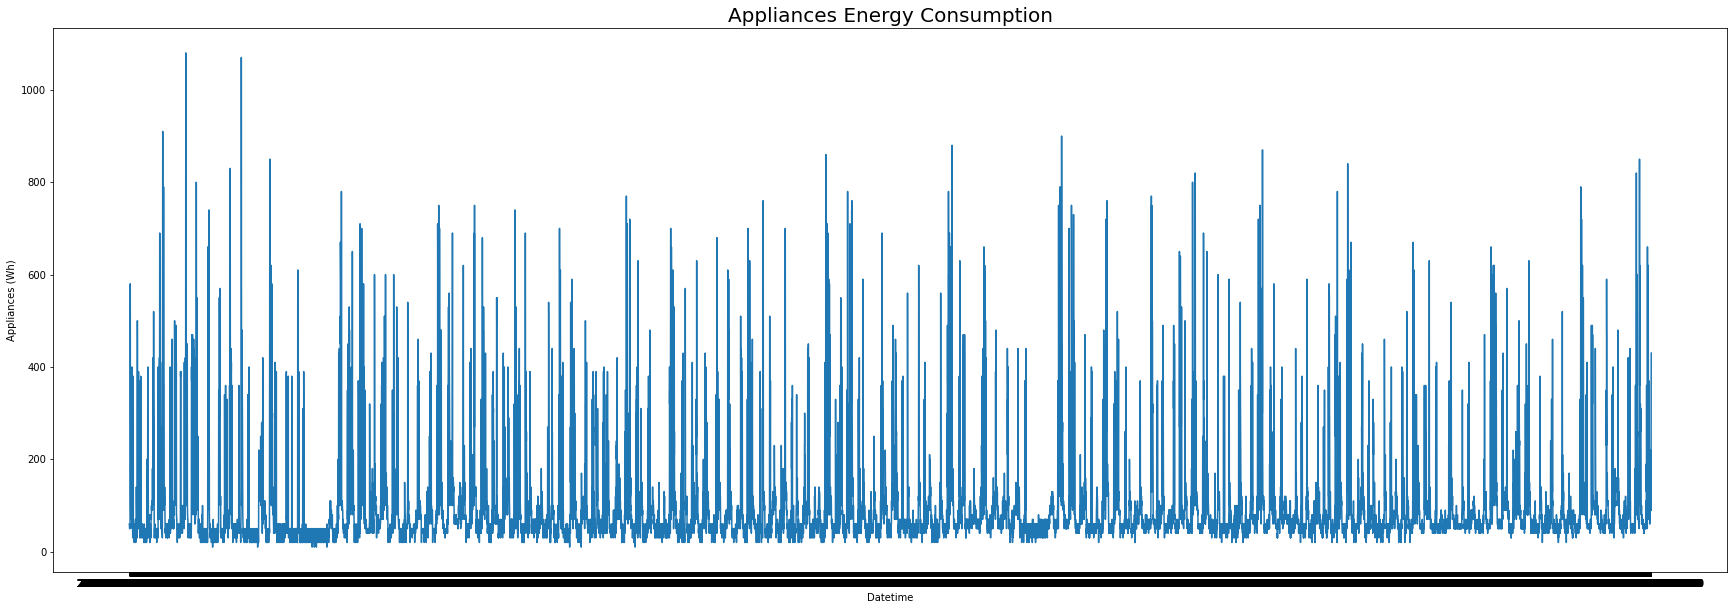

In [7]:
dates = dataset['date'].values
appliances  = dataset['Appliances'].values

plt.figure(figsize=(30,10))
plt.plot(dates, appliances)
plt.ylabel('Appliances (Wh)')
plt.xlabel('Datetime')
plt.title('Appliances Energy Consumption',
          fontsize=20);



In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

**Modelling**

In [9]:
#Validation set 20%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(appliances, dates, test_size = 0.2, random_state = 0 , shuffle=False)

In [25]:
train_set = windowed_dataset(appliances, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

#Implementasi LSTM, Sequential
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [26]:
#Implementasi Learning Rate Pada Optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [27]:
Mae = (dataset['Appliances'].max() - dataset['Appliances'].min()) * 10/100
print(f'{Mae} adalah nilai < 10% skala data.')

107.0 adalah nilai < 10% skala data.


In [28]:
#Implementasi Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 48 and logs.get('val_mae')< 48):
      print("\nTraining dihentikan, nilai MAE sudah mencapai target yaitu < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [29]:
history = model.fit(train_set,epochs=100, validation_data=test_set, callbacks=[callbacks])

Epoch 1/100
197/197 [==============================] - 30s 134ms/step - loss: 95.4583 - mae: 95.9583 - val_loss: 89.0851 - val_mae: 89.5851
Epoch 2/100
197/197 [==============================] - 26s 133ms/step - loss: 69.8820 - mae: 70.3809 - val_loss: 40.5705 - val_mae: 41.0705
Epoch 3/100
197/197 [==============================] - 26s 132ms/step - loss: 48.8871 - mae: 49.3747 - val_loss: 37.9764 - val_mae: 38.4720
Epoch 4/100
197/197 [==============================] - 26s 132ms/step - loss: 42.3588 - mae: 42.8509 - val_loss: 30.1377 - val_mae: 30.6247

Training dihentikan, nilai MAE sudah mencapai target yaitu < 10% skala data


**Evaluation**

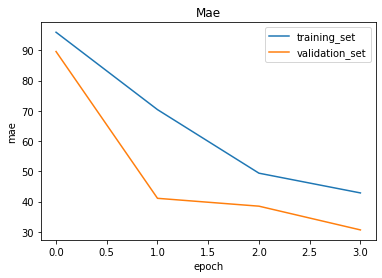

In [30]:
#Plot Akurasi
plt.title('Mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.plot(history.history['mae'], label='training_set')
plt.plot(history.history['val_mae'], label='validation_set')
plt.legend()

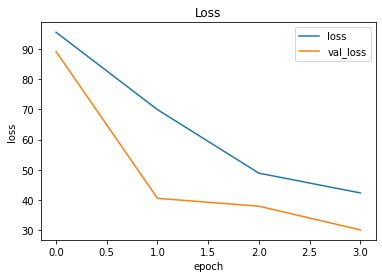

In [31]:
#Plot Akurasi
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()